In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# To build the model, we'll use the Keras Functional API (no need to wory about version mismatch because we're using the Keras thats within TensorFlow already)
# Using the functional API because: looks cleaner/simpler, easy to create branches, can define models with multiple inputs and outputs, dont have to type out "tf.keras.blah blah..."
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

## Again, these steps are model agnostic:
1. load in the data
2. build model
3. train model
4. evaluate model
5. make predictions

We are using the Fashion MNIST dataset, because it is more challenging than the (solved) MNIST dataset which is too easy for modern ML. The format of the images in this dataset are the same (28x28 and grayscale).

We are also going to use the CIFAR-10 dataset, which has 32x32 color images of different things, like horse, dog, etc.

In [ ]:
# First, fashion MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("x_train.shape:", x_train.shape)

4431872/4422102 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


In [ ]:
# X.shape is N x 28 x 28. CNN expects N x H x W x C, though, so we must reshape (add a color channel) to N x 28 x 28 x 1
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train.shape:", x_train.shape)

x_train.shape: (60000, 28, 28, 1)


In [ ]:
# number of classes
K = len(set(y_train)) # cast y_train to a set (unique elements)
print("number of classes:", K)

number of classes: 10


In [ ]:
# Build model using the Keras functional API
# We will use a few strided convolutional layers (stride = 2), a flatten, and 2 dense (with 2nd having softmax activation)
i = Input(shape=x_train[0].shape)
# param 1: # of output feature maps. like Dense layer, no need to specify # of input features (keras does that based off previous layer)
# param 2: filter dimensions (good sizes are 3x3, 5x5, and 7x7)
# param 3: stride (speed of filter as its passed along the image)
# param 4: activation function (normally a relu or some variant thereof)
# param 5: mode (remember: valid = N - K + 1, same = N, and full = N + K - 1, full has atypical usage)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
# remember: we can also add dropout regularization before the Dense layers if desired
# doesnt really make sense to do this for the conv layers though, but you can try
# e.g. x = Dropout(0.2)(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

# first arg: input/list of inputs, second arg: output/list of outputs
model = Model(i, x)

note:
- Conv2D because there are 2 spatial dimensions
- there is also Conv1D() and Conv3D()
- Conv1D could be used for time-varying signals
- Conv3D could be used with vdieo (height, width, time) or voxels (height, width, depth) such as in medical imaging data
- pixel = "picture element". voxel = "volume element"

In [ ]:
# Compile and fit
# note: make sure to use the GPU for this
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)
# Notice how accuracy isnt as high, since its more difficult than classic MNIST

Epoch 1/15
1875/1875 [==============================] - 19s 4ms/step - loss: 0.5175 - accuracy: 0.8080 - val_loss: 0.4073 - val_accuracy: 0.8483
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3534 - accuracy: 0.8678 - val_loss: 0.3319 - val_accuracy: 0.8792
Epoch 3/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3043 - accuracy: 0.8853 - val_loss: 0.3123 - val_accuracy: 0.8849
Epoch 4/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2703 - accuracy: 0.8976 - val_loss: 0.3036 - val_accuracy: 0.8905
Epoch 5/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2462 - accuracy: 0.9064 - val_loss: 0.3056 - val_accuracy: 0.8889
Epoch 6/15
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2276 - accuracy: 0.9131 - val_loss: 0.2995 - val_accuracy: 0.8955
Epoch 7/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2088 - accuracy: 0.9195 - val_loss: 0.3060 - val_accuracy

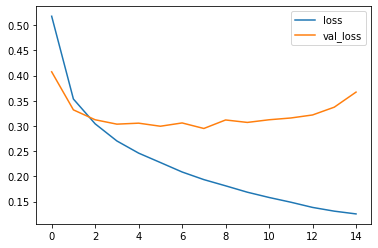

In [ ]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
# Model seems to be overfitting since validation loss goes up slightly

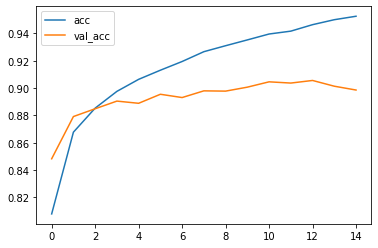

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
# Looks like validation accuracy stays steady, while the validation loss goes up
# This could mean that the model is getting more and more confident in its incorrect predictions
# Accuracy isnt effected when predictions are more incorrect. Loss is effected, though (goes up)
# If training accuracy is still improving while validation accuracy has leveled off, this is another sign 
# of overfitting, and the model is learning to match the noise in the training set

In [10]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  '''
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting "normalize=True
  '''
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=l)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  
  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
# Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split()
# Its mainly confusing t-shirt/top (0) with shirt (6) and shirt (6) with coat (4)

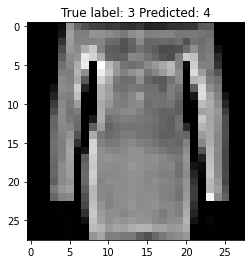

In [ ]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], p_test[i]));

In [3]:
# Now, CIFAR-10
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
# Data is N x 32 x 32 x 3, but the labels are N x 1 (an inconvencience, but easily fixed with Flatten())
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)

170508288/170498071 [==============================] - 13s 0us/step
x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000,)


In [4]:
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


In [6]:
# Build the model (same architecture as before, except this:)
# If input has 1 color channel, first filter size is 1 x 3 x 3 x 32. Now we have 3 chanels, so size of first conv weight (filter) is 3 x 3 x 3 x 32
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

In [7]:
# Compile and fit (again, use GPU)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
1563/1563 [==============================] - 19s 5ms/step - loss: 1.5345 - accuracy: 0.4417 - val_loss: 1.3154 - val_accuracy: 0.5345
Epoch 2/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2186 - accuracy: 0.5652 - val_loss: 1.1052 - val_accuracy: 0.6049
Epoch 3/15
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0709 - accuracy: 0.6187 - val_loss: 1.0353 - val_accuracy: 0.6371
Epoch 4/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9580 - accuracy: 0.6591 - val_loss: 0.9491 - val_accuracy: 0.6681
Epoch 5/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8623 - accuracy: 0.6932 - val_loss: 0.9268 - val_accuracy: 0.6793
Epoch 6/15
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7800 - accuracy: 0.7228 - val_loss: 0.9107 - val_accuracy: 0.6842
Epoch 7/15
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7107 - accuracy: 0.7483 - val_loss: 0.8858 - val_accuracy

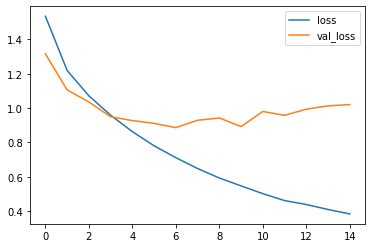

In [9]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
# Again, overfitting

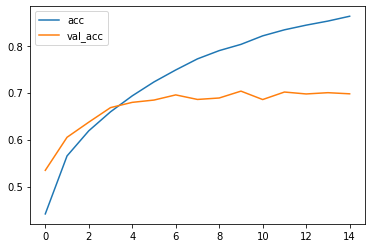

In [8]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

Confusion matrix, without normalization
[[769  23  58  10  15   4   8  12  73  28]
 [ 20 814   9   5   7   6   4   2  37  96]
 [ 66   8 625  38  90  56  40  47  16  14]
 [ 31  14 114 420  80 193  63  40  18  27]
 [ 29   3 102  40 631  47  40  84  16   8]
 [ 23   5  70 141  56 597  20  69  12   7]
 [ 17   7  68  52  40  31 756   7  10  12]
 [ 20   3  38  23  53  54   2 786   8  13]
 [ 68  32  18   9   8   4   3   4 832  22]
 [ 57  92  14  11   2   8   4  24  43 745]]


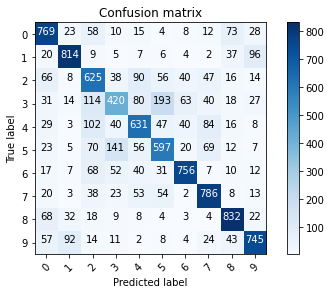

In [11]:
# Confusion matrix
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [13]:
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

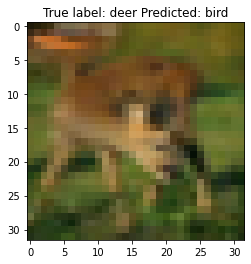

In [20]:
# Show misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));